#  Analyse spectra holo at AuxTel for Configuration PSF1D


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : September 22th  2022
- last update : October 1st 2022


- **kernel anaconda3_auxtel** at CC or **python 3** locally

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

/opt/conda/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

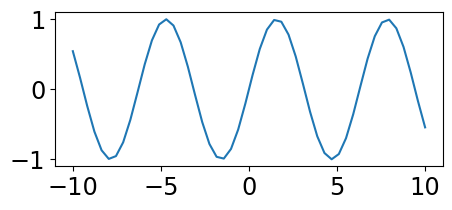

In [3]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [4]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [5]:
from datetime import datetime,date

In [6]:
#pip install fpdf
#from fpdf import FPDF

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [7]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [8]:
string_date

'2022-10-04'

In [9]:
from iminuit import Minuit
import iminuit

In [10]:
iminuit.__version__

'2.8.4'

In [11]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor,dumpParameters,dumpfitparameters
from spectractor.extractor.spectrum import Spectrum, detect_lines, calibrate_spectrum
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, HGAMMA, HDELTA ,O2_1, O2_2, O2B,H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [12]:
from time import sleep

In [13]:
from astropy.time import Time
import astropy.units as u

In [14]:
import pickle

# Calibration line

In [15]:
ATMOSPHERIC_LINES_CALIB = [O2B,O2_1, O2_2]
HYDROGEN_LINES_CALIB = [HALPHA, HBETA, HGAMMA, HDELTA]

setatml = set(ATMOSPHERIC_LINES_CALIB)
sethdryl = set(HYDROGEN_LINES_CALIB )

LINES_CALIB = list(sethdryl.union(setatml))

lines_calib = Lines(LINES_CALIB , hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)

# Function

In [16]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^exposure_.*([0-9][0-9][0-9][0-9][0-9])_postisrccd.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None


In [17]:
def subdir_tag_forsorting(subdir):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('.*([0-9][0-9][0-9][0-9][0-9])$', subdir)
    if len(m)>0:
        return m[0]
    else:
        return None


In [18]:
file_tag_forsorting('exposure_2022031600330_postisrccd.fits')

'00330'

In [19]:
subdir_tag_forsorting('2022031600330')

'00330'

# Config

In [20]:
# path index for each month
DATE="20220630"
#DATE="20211104"
filterdispersername = "empty~holo4_003"
#filterdispersername = "BG40~holo4_003"
#filterdispersername = "FELH0600~holo4_003"
imagemode = "postISRCCD"
#imagemode = "unflattened"
FLAG_RECALIB = False

In [21]:
version="v5.0"

In [22]:
# Choose the config filename
list_of_spectractorconfigfiles= ['auxtel_config_holo_DECONVOLUTION_PSF1D.ini' ,
                                 'auxtel_config_holo_DECONVOLUTION_PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF2DFFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DFFM300650.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotA.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotB.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotC.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotD.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF1D_BG40.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF1DTRUNC.ini']
config_idx = 13
                                
configfilename= os.path.join("./config",list_of_spectractorconfigfiles[config_idx])
#configdir = (list_of_spectractorconfigfiles[config_idx].split("_")[-1]).split(".") [0]
configdir = "config_" + (list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_")[-1]).split(".") [0]

In [23]:
configdir 

'config_DECONVOLUTION_PSF1DTRUNC'

In [24]:
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_PSF1DTRUNC.ini


In [25]:
load_config(configfilename)

No rebinning: parameters.REBIN is forced to 1.


In [26]:
configmode = list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_DECONVOLUTION_")[-1].split(".") [0]
configmode

'PSF1DTRUNC'

## Parameters

In [27]:
dumpParameters()

ASTROMETRYNET_DIR 
BGD_ORDER 1
CALIB_BGD_NPARAMS 4
CALIB_BGD_ORDER 3
CALIB_BGD_WIDTH 15
CALIB_PEAK_WIDTH 7
CALIB_SAVGOL_ORDER 2
CALIB_SAVGOL_WINDOW 5
CCD_ARCSEC2RADIANS 4.84813681109536e-06
CCD_GAIN 1.1
CCD_IMSIZE 4096
CCD_MAXADU 170000
CCD_PIXEL2ARCSEC 0.0952
CCD_PIXEL2MM 0.01
CCD_REBIN 1
CONFIG_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/../config/
DEBUG False
DEBUG_LOGGING False
DISPERSER_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/
DISPLAY False
DISTANCE2CCD 175
DISTANCE2CCD_ERR 0.75
FGB37 {'label': 'FGB37', 'min': 350, 'max': 750}
FILTERS [{'label': 'RG715', 'min': 690, 'max': 1100}, {'label': 'FGB37', 'min': 350, 'max': 750}, {'label': 'Halfa', 'min': 0.0006431, 'max': 0.0006686999999999999}, {'label': 'Z-Gunn', 'min': 800, 'max': 1100}]
FLAM_TO_ADURATE 5175865186660.421
GRATING_ORDER_2OVER1 0.1
GROOVES_PER_MM 350
HAL

# Path

In [28]:
HOSTCC=True
LAPTOP=False

In [29]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
    if configdir == "":
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
    else:
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
        path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
        path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
        path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)

else:
    if not LAPTOP:
        path_auxtel="/Users/sylvie/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/sylvie/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
    else:
        path_auxtel="/Users/dagoret/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/dagoret/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
        


In [30]:
path_output_spectractor

'/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630'

In [31]:
! ls -l $path_output_spectractor

total 0
drwxrws--- 1 dagoret lsst 2 Oct  4 21:04 2022063000046
drwxrws--- 1 dagoret lsst 2 Oct  4 21:05 2022063000060
drwxrws--- 1 dagoret lsst 2 Oct  4 21:05 2022063000061
drwxrws--- 1 dagoret lsst 2 Oct  4 21:05 2022063000076
drwxrws--- 1 dagoret lsst 2 Oct  4 21:05 2022063000077
drwxrws--- 1 dagoret lsst 2 Oct  4 21:05 2022063000091
drwxrws--- 1 dagoret lsst 2 Oct  4 21:04 2022063000092
drwxrws--- 1 dagoret lsst 2 Oct  4 21:04 2022063000106
drwxrws--- 1 dagoret lsst 2 Oct  4 21:04 2022063000107
drwxrws--- 1 dagoret lsst 2 Oct  4 21:04 2022063000121
drwxrws--- 1 dagoret lsst 2 Oct  4 21:04 2022063000122
drwxrws--- 1 dagoret lsst 2 Oct  4 21:05 2022063000136
drwxrws--- 1 dagoret lsst 2 Oct  4 21:04 2022063000137
drwxrws--- 1 dagoret lsst 2 Oct  4 21:05 2022063000157
drwxrws--- 1 dagoret lsst 2 Oct  4 21:05 2022063000158
drwxrws--- 1 dagoret lsst 2 Oct  4 21:05 2022063000177
drwxrws--- 1 dagoret lsst 2 Oct  4 21:05 2022063000178
drwxrws--- 1 dagoret lsst 2 Oct  4 21:04 2022063000216
dr

In [32]:
# standard configuration for spectractor
#config = os.path.join(path_spectractor_config,"auxtel.ini")
#config=os.path.join("./config",configfilename)
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_PSF1DTRUNC.ini


In [33]:
load_config(configfilename)

No rebinning: parameters.REBIN is forced to 1.


## Logbook for file selection

In [34]:
filename_logbook='logbooks/auxtellogbook_'+filterdispersername+"_"+DATE+'_' + version+'.csv'

In [35]:
df=pd.read_csv(filename_logbook,index_col=0)

In [36]:
pd.set_option('display.max_rows', None)

In [37]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2022-06-30T23:15:22.567,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022063000046_postisrccd.fits,46,HD142331,empty_1,holo4_003,1.403795,30.0,...,7.2,20.0,4.9,NaN,NaN,NaN,NaN,,NaN,NaN
1,1,2022-06-30T23:24:31.859,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022063000060_postisrccd.fits,60,HD142331,empty_1,holo4_003,1.361241,30.0,...,7.2,21.0,4.1,NaN,NaN,NaN,NaN,,NaN,NaN
2,2,2022-06-30T23:25:14.943,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022063000061_postisrccd.fits,61,HD142331,empty_1,holo4_003,1.358098,30.0,...,7.2,21.0,5.8,NaN,NaN,NaN,NaN,,NaN,NaN
3,3,2022-06-30T23:35:50.719,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022063000076_postisrccd.fits,76,HD185975,empty_1,holo4_003,2.024822,30.0,...,7.2,21.0,5.1,NaN,NaN,NaN,NaN,,NaN,NaN
4,4,2022-06-30T23:36:33.674,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022063000077_postisrccd.fits,77,HD185975,empty_1,holo4_003,2.024353,30.0,...,7.1,21.0,5.2,NaN,NaN,NaN,NaN,,NaN,NaN
5,5,2022-06-30T23:46:52.409,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022063000091_postisrccd.fits,91,HD142331,empty_1,holo4_003,1.274707,30.0,...,7.0,21.0,5.4,NaN,NaN,NaN,NaN,,NaN,NaN
6,6,2022-06-30T23:47:35.500,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022063000092_postisrccd.fits,92,HD142331,empty_1,holo4_003,1.272288,30.0,...,7.0,21.0,5.1,NaN,NaN,NaN,NaN,,NaN,NaN
7,7,2022-06-30T23:56:45.653,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022063000106_postisrccd.fits,106,HD142331,empty_1,holo4_003,1.243106,30.0,...,6.9,22.0,3.6,NaN,NaN,NaN,NaN,,NaN,NaN
8,8,2022-06-30T23:57:28.696,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022063000107_postisrccd.fits,107,HD142331,empty_1,holo4_003,1.240955,30.0,...,6.8,22.0,5.3,NaN,NaN,NaN,NaN,,NaN,NaN
9,9,2022-07-01T00:06:37.301,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022063000121_postisrccd.fits,121,HD142331,empty_1,holo4_003,1.215102,30.0,...,6.7,22.0,6.1,NaN,NaN,NaN,NaN,,NaN,NaN


## Selection of input files

In [38]:
df_good=df
df_good["quality"] = 1

In [39]:
for spectra_file in df_good["file"]:
    print(spectra_file)

exposure_2022063000046_postisrccd.fits
exposure_2022063000060_postisrccd.fits
exposure_2022063000061_postisrccd.fits
exposure_2022063000076_postisrccd.fits
exposure_2022063000077_postisrccd.fits
exposure_2022063000091_postisrccd.fits
exposure_2022063000092_postisrccd.fits
exposure_2022063000106_postisrccd.fits
exposure_2022063000107_postisrccd.fits
exposure_2022063000121_postisrccd.fits
exposure_2022063000122_postisrccd.fits
exposure_2022063000136_postisrccd.fits
exposure_2022063000137_postisrccd.fits
exposure_2022063000157_postisrccd.fits
exposure_2022063000158_postisrccd.fits
exposure_2022063000177_postisrccd.fits
exposure_2022063000178_postisrccd.fits
exposure_2022063000216_postisrccd.fits
exposure_2022063000231_postisrccd.fits
exposure_2022063000232_postisrccd.fits
exposure_2022063000246_postisrccd.fits
exposure_2022063000247_postisrccd.fits
exposure_2022063000261_postisrccd.fits
exposure_2022063000262_postisrccd.fits
exposure_2022063000276_postisrccd.fits
exposure_2022063000277_po

## Selection of Spectractor output files

In [40]:
# total number of exposures
NBEXP=0
# total number of exposures without dir
NBEXPNODIR=0
# total number of exposures with dir
NBEXPWTHDIR=0
# total number of exposures with plots
NBEXPWTHPLT=0
# total number of exposures with spectra
NBEXPWTHSPEC=0

# list of exposures
LISTNUM=[]
# list of exposure without dir (not run spectraction)
LISTNUMNODIR=[]
# list of exposure with dir (spectraction has been run)
LISTNUMWTHDIR=[]
# list of exposures with plots (Spectractor has run up to some point)
LISTNUMWTHPLOTS=[]
# list of exposures with spectraction output (Spectractor has completed)
LISTNUMWTHSPECTR=[]

# list of selected spectra path
List_of_spectra_path=[]

In [41]:
list_of_files=os.listdir(path_output_spectractor)
list_of_files=sorted(list_of_files)


print("list of subdir found ",list_of_files)

for subdir in list_of_files:
    
    
    #tag = file_tag_forsorting(subdir)
    tag = subdir_tag_forsorting(subdir)
    
        
    print(tag)    
    #if tag is not None and int(tag)<317:
    #    continue
    if tag is None :
        continue
  
    
    
    fulldir=os.path.join(path_output_spectractor,subdir)



    if not os.path.isdir(fulldir):
        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is not a directory".format(subdir))
        

        NBEXPNODIR+=1


    else:

        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is a directory".format(subdir))

        tagname=subdir_tag_forsorting(subdir)
        print("tagname= {}".format(tagname))
        #targetname=file_target(subdir)
        #print("targetname= {}".format(targetname))
        



        NBEXP += 1
        LISTNUM.append(tagname)



        dir_plots=os.path.join(fulldir,"plots")
        dir_spectration = os.path.join(fulldir, "basespec")

        flag_empty1 = True
        flag_empty2 = True


        if os.path.isdir(dir_plots):
            if any(os.scandir(dir_plots)):
                print("dir_plots is not empty")
                NBEXPWTHPLT+=1
                LISTNUMWTHPLOTS.append(tagname)
                flag_empty1 = False

            else:
                print("dir_plots is empty")


        if os.path.isdir(dir_spectration):
            if any(os.scandir(dir_spectration)):
                print("dir_spectration is not empty")
                NBEXPWTHSPEC+=1
                LISTNUMWTHSPECTR.append(tagname)
                flag_empty2 = False
                List_of_spectra_path.append(dir_spectration)

            else:
                print("dir_spectration is empty")

        if flag_empty1 and flag_empty2 :
            NBEXPNODIR+=1
            LISTNUMNODIR.append(tagname)
        else:
            NBEXPWTHDIR += 1
            LISTNUMWTHDIR.append(tagname)



print("-----------------------------------------------------------------")


#LISTNUM=sorted(LISTNUM)
#LISTNUMNODIR=sorted(LISTNUMNODIR)
#LISTNUMWTHDIR=sorted(LISTNUMWTHDIR)
#LISTNUMWTHPLOTS=sorted(LISTNUMWTHPLOTS)
#LISTNUMWTHSPECTR=sorted(LISTNUMWTHSPECTR)
List_of_spectra_path=sorted(List_of_spectra_path)

print("Full list of Exposures : .......................{}".format(LISTNUM))
print("Full list of Exposures without output dir: .....{}".format(LISTNUMNODIR))
print("Full list of Exposures with output dir: ....... {}".format(LISTNUMWTHDIR))
print("Full list of Exposures with output plots: ..... {}".format(LISTNUMWTHPLOTS))
print("Full list of Exposures with output spectra: ....{}".format(LISTNUMWTHSPECTR))




print("Total number of exposures : .....................{}".format(NBEXP))
print("Total number of exposures without dir : .........{}".format(NBEXPNODIR))
print("Total number of exposures with dir :.............{}".format(NBEXPWTHDIR))
print("Total number of exposures with plots : ..........{}".format(NBEXPWTHPLT))
print("Total number of exposures with spectra: .........{}".format(NBEXPWTHSPEC))


list of subdir found  ['2022063000046', '2022063000060', '2022063000061', '2022063000076', '2022063000077', '2022063000091', '2022063000092', '2022063000106', '2022063000107', '2022063000121', '2022063000122', '2022063000136', '2022063000137', '2022063000157', '2022063000158', '2022063000177', '2022063000178', '2022063000216', '2022063000231', '2022063000246', '2022063000247', '2022063000261', '2022063000262', '2022063000276', '2022063000277', '2022063000292', '2022063000317', '2022063000318', '2022063000337', '2022063000338', '2022063000352', '2022063000353', '2022063000367', '2022063000368', '2022063000390', '2022063000391', '2022063000405', '2022063000406', '2022063000421', '2022063000436', '2022063000450', '2022063000451', '2022063000476', '2022063000491', '2022063000492', '2022063000521', '2022063000522', '2022063000536', '2022063000537', '2022063000562', '2022063000589', '2022063000590']
00046
---------------------------------------------
2022063000046  	   00046
2022063000046 is

In [42]:
#dir_spectra="outputs_reprocess"
print(List_of_spectra_path)

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000046/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000060/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000061/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000076/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000077/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000091/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/20

In [43]:
config

'./config/auxtel_config_holo_DECONVOLUTION_PSF1DTRUNC.ini'

## Extraction of spectra

In [44]:
all_files_spectra = []
all_files_spectrogram = []
all_files_lines = []
all_files_table = []

# loop on topdir
for dir_spectra in List_of_spectra_path:
    for filename in os.listdir(dir_spectra):
        if re.search("_spectrum.fits$",filename):
            the_file_spectrum=os.path.join(dir_spectra,filename)
            all_files_spectra.append(the_file_spectrum)
            the_file_spectrogram=the_file_spectrum.replace("_spectrum","_spectrogram")
            all_files_spectrogram.append(the_file_spectrogram)
            the_file_lines=the_file_spectrum.replace("_spectrum.fits","_lines.csv")
            all_files_lines.append(the_file_lines)
            the_file_table=the_file_spectrum.replace("_spectrum.fits","_table.csv")
            all_files_table.append(the_file_table)
    

In [45]:
all_files_spectra[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000046/basespec/exposure_2022063000046_postisrccd_spectrum.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000060/basespec/exposure_2022063000060_postisrccd_spectrum.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000061/basespec/exposure_2022063000061_postisrccd_spectrum.fits']

In [46]:
all_files_spectrogram[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000046/basespec/exposure_2022063000046_postisrccd_spectrogram.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000060/basespec/exposure_2022063000060_postisrccd_spectrogram.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000061/basespec/exposure_2022063000061_postisrccd_spectrogram.fits']

In [47]:
all_files_lines[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000046/basespec/exposure_2022063000046_postisrccd_lines.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000060/basespec/exposure_2022063000060_postisrccd_lines.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000061/basespec/exposure_2022063000061_postisrccd_lines.csv']

In [48]:
all_files_table[:3] 

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000046/basespec/exposure_2022063000046_postisrccd_table.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000060/basespec/exposure_2022063000060_postisrccd_table.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000061/basespec/exposure_2022063000061_postisrccd_table.csv']

## Selection of good spectra

In [49]:
all_good_spectra_spectrum_files = sorted(all_files_spectra)

In [50]:
N=len(all_good_spectra_spectrum_files)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

## One Spectrum

In [51]:
#idx=7 # Big Shift
#idx = 8 # Shift, I don't know why
idx = 9 # OK
#idx = 10 # OK
#idx = 11 # OK
#idx = 12 # 0K
#idx = 13 # strange shift after recalib
#idx = 14 # OK
#idx = 15 # Shift
#idx = 16 # BAD Spectrum Nothing
#idx = 17 # OK
#idx = 18 # trange shift after recalib
#idx = 19 # OK
#idx = 20 # OK
#idx = 21 # OK
#idx = 22 # BAD Spectrum
#idx = 24 # OK


fullfilename = all_good_spectra_spectrum_files[idx]
    
filename = os.path.basename(fullfilename)
print(idx,")",filename," ",fullfilename)
    
    
fig=plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(3, 1, 1)
    
filename= os.path.basename(fullfilename)
tag=file_tag_forsorting(filename.split(".")[0])

    
   
     
s=Spectrum(fullfilename, config=config,fast_load=False)
label=filename.split('.')[0]+" "
label = str(idx) +"):"+label
#s.plot_spectrum(ax=ax1,force_lines=True,label=label)
s.plot_spectrum(ax=ax1,force_lines=True,label=label)

   
if FLAG_RECALIB: 
    parameters.DEBUG=True
    parameters.LIVE_FIT=True
    ax2 = fig.add_subplot(3, 1, 2)
    print(" === RECALIBRATE lines === ")
    s.lines = lines_calib
    newlambdas = calibrate_spectrum(s, with_adr=True)
    label=str(idx) +"):"+filename.split('.')[0]+" recalibrated"
    s.plot_spectrum(ax=ax2,force_lines=True,label=label)
    t=s.lines.print_detected_lines(print_table=True)
    print(t["Shift"])
    print(t["Chisq"])
    
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.plot(newlambdas,s.data,"r-")
    s.lines.plot_detected_lines(ax=ax3)
    s.lines.plot_atomic_lines(ax=ax3,force=True)
    ax3.set_xlim(parameters.LAMBDA_MIN, parameters.LAMBDA_MAX)
    ax3.grid()
    
    

plt.show()
    

9 ) exposure_2022063000121_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000121/basespec/exposure_2022063000121_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T00:07:07.542
set expo to 30.0
set airmass to 1.214369173694501
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -29.12545877892445
set temperature to 6.7
set pressure to 740.3
set humidity to 22.0
set lambda_ref to 563.003359926254
set parallactic_angle to -132.5127736122312


2022-10-04 21:50:45  astropy    _showwarning         WARNING AstropyDeprecationWarning: The update_default_config function is deprecated and may be removed in a future version.
2022-10-04 21:50:50  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


target_name = HD142331, Selected object name for Simbad : HD142331
 MAIN_ID        RA           DEC      ...  Z_VALUE   SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1


In [52]:
parameters.DEBUG=False
parameters.LIVE_FIT=False

## All Spectra

In [53]:
parameters.DISPLAY=True

FLAG_ORDER2 = True

infos = []
all_lambdas=[]
all_data=[]
all_data_err=[]

if FLAG_ORDER2:
    all_lambdas_order2=[]
    all_data_order2=[]
    all_data_err_order2=[]

all_num=[]
all_figs = []


idx=0
for fullfilename in all_good_spectra_spectrum_files:
    
    filename = os.path.basename(fullfilename)
    print("============================",idx,")",filename," ",fullfilename,"==============================")
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    
    filename= os.path.basename(fullfilename)
    tag=file_tag_forsorting(filename.split(".")[0])
    all_num.append(tag)
    
   
     
    s=Spectrum(fullfilename, config=config,fast_load=False)
    label=filename.split('.')[0]+" "
    label = str(idx) +"):"+label
    s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    print("=== ORIGINAL CALIB lines === ")
    s.lines.print_detected_lines(print_table=True)
    
    if FLAG_RECALIB: 
        print(" === RECALIBRATE lines === ")
        s.lines = lines_calib
        lambdas = calibrate_spectrum(s, with_adr=False)
        label=filename.split('.')[0]+" recalibrated"
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
        t=s.lines.print_detected_lines(print_table=True)
        print(t["Shift"])
    
    
    
    
    all_lambdas.append(s.lambdas)
    all_data.append(s.data)
    all_data_err.append(s.err)
    
    if FLAG_ORDER2:
        all_lambdas_order2.append(s.lambdas_order2)
        all_data_order2.append(s.data_order2)
        all_data_err_order2.append(s.err_order2)
    
    ax2 = fig.add_subplot(1, 2, 2)
    
    fullfilename2=all_files_spectrogram[idx]
    
    s.load_spectrogram(fullfilename2)
    s.plot_spectrogram(ax=ax2,scale="log")
    
    
    infos.append([idx,s.target.label,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    
    
    plt.show()
    all_figs.append(fig)
    
    idx+=1
    

============================ 0 ) exposure_2022063000046_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000046/basespec/exposure_2022063000046_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:15:52.802
set expo to 30.0
set airmass to 1.402459240971464
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -41.96623354193085
set temperature to 7.2
set pressure to 740.55
set humidity to 20.0
set lambda_ref to 563.93605687301
set parallactic_angle to -124.8487550659438
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:51:05  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_2  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 1 ) exposure_2022063000060_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000060/basespec/exposure_2022063000060_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:25:02.105
set expo to 30.0
set airmass to 1.360041430750229
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -39.67163746158988
set temperature to 7.2
set pressure to 740.5999999999999
set humidity to 21.0
set lambda_re

2022-10-04 21:51:06  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_3  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 2 ) exposure_2022063000061_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000061/basespec/exposure_2022063000061_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:25:45.183
set expo to 30.0
set airmass to 1.356908431009178
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -39.49196365944726
set temperature to 7.2
set pressure to 740.55
set humidity to 21.0
set lambda_ref to 563.82

2022-10-04 21:51:07  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_4  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 3 ) exposure_2022063000076_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000076/basespec/exposure_2022063000076_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:36:20.957
set expo to 30.0
set airmass to 2.024642201243401
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -107.6853353240028
set temperature to 7.2
set pressure to 740.5
set humidity to 21.0
set lambda_ref to 566.260

2022-10-04 21:51:08  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_5  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 4 ) exposure_2022063000077_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000077/basespec/exposure_2022063000077_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:37:03.905
set expo to 30.0
set airmass to 2.024173018332033
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -107.5062921822842
set temperature to 7.1
set pressure to 740.5
set humidity to 21.0
set lambda_ref to 565.983

2022-10-04 21:51:10  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_6  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 5 ) exposure_2022063000091_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000091/basespec/exposure_2022063000091_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:47:22.642
set expo to 30.0
set airmass to 1.273783738235489
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -34.07268431209909
set temperature to 7.0
set pressure to 740.4000000000001
set humidity to 21.0
set lambda_re

2022-10-04 21:51:11  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_7  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 6 ) exposure_2022063000092_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000092/basespec/exposure_2022063000092_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:48:05.745
set expo to 30.0
set airmass to 1.271366736545295
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -33.89300762332066
set temperature to 7.0
set pressure to 740.4000000000001
set humidity to 21.0
set lambda_re

2022-10-04 21:51:12  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_8  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 7 ) exposure_2022063000106_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000106/basespec/exposure_2022063000106_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:57:15.887
set expo to 30.0
set airmass to 1.242285058752789
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -31.59578644296563
set temperature to 6.9
set pressure to 740.45
set humidity to 22.0
set lambda_ref to 563.41

2022-10-04 21:51:14  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_9  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 8 ) exposure_2022063000107_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000107/basespec/exposure_2022063000107_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:57:58.938
set expo to 30.0
set airmass to 1.24014045646283
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -31.41610504228732
set temperature to 6.8
set pressure to 740.35
set humidity to 22.0
set lambda_ref to 563.384

2022-10-04 21:51:15  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_10 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 9 ) exposure_2022063000121_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000121/basespec/exposure_2022063000121_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T00:07:07.542
set expo to 30.0
set airmass to 1.214369173694501
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -29.12545877892445
set temperature to 6.7
set pressure to 740.3
set humidity to 22.0
set lambda_ref to 563.003

2022-10-04 21:51:16  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_11 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 10 ) exposure_2022063000122_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000122/basespec/exposure_2022063000122_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T00:07:50.546
set expo to 30.0
set airmass to 1.212465919143477
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -28.94578049328431
set temperature to 6.7
set pressure to 740.3
set humidity to 22.0
set lambda_ref to 562.71

2022-10-04 21:51:17  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_12 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 11 ) exposure_2022063000136_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000136/basespec/exposure_2022063000136_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T00:17:03.362
set expo to 30.0
set airmass to 1.189474148247214
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -26.63774776435873
set temperature to 6.5
set pressure to 740.35
set humidity to 23.0
set lambda_ref to 562.9

2022-10-04 21:51:18  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_13 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 12 ) exposure_2022063000137_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000137/basespec/exposure_2022063000137_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T00:17:46.369
set expo to 30.0
set airmass to 1.187791756488419
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -26.45807626820024
set temperature to 6.4
set pressure to 740.35
set humidity to 23.0
set lambda_ref to 562.5

2022-10-04 21:51:19  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_14 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 13 ) exposure_2022063000157_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000157/basespec/exposure_2022063000157_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T00:33:15.985
set expo to 30.0
set airmass to 1.986407572536483
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -93.23036918012215
set temperature to 6.3
set pressure to 740.3
set humidity to 22.0
set lambda_ref to 565.42

2022-10-04 21:51:21  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_15 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 14 ) exposure_2022063000158_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000158/basespec/exposure_2022063000158_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T00:33:59.151
set expo to 30.0
set airmass to 1.985932062249065
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -93.05069543496722
set temperature to 6.3
set pressure to 740.3
set humidity to 23.0
set lambda_ref to 562.06

2022-10-04 21:51:23  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_16 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 15 ) exposure_2022063000177_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000177/basespec/exposure_2022063000177_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T00:49:00.740
set expo to 30.0
set airmass to 1.128326261121029
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -18.6343631284564
set temperature to 6.1
set pressure to 740.25
set humidity to 23.0
set lambda_ref to 562.70

2022-10-04 21:51:24  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_17 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 16 ) exposure_2022063000178_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000178/basespec/exposure_2022063000178_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T00:49:43.755
set expo to 30.0
set airmass to 1.127250273363943
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -18.45468678378293
set temperature to 6.1
set pressure to 740.25
set humidity to 23.0
set lambda_ref to 562.5

2022-10-04 21:51:25  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_18 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 17 ) exposure_2022063000216_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000216/basespec/exposure_2022063000216_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T01:19:34.765
set expo to 30.0
set airmass to 1.092661663242822
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -10.97145048814478
set temperature to 5.6
set pressure to 740.25
set humidity to 25.0
set lambda_ref to 561.8

2022-10-04 21:51:27  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_19 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 18 ) exposure_2022063000231_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000231/basespec/exposure_2022063000231_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T01:29:30.756
set expo to 30.0
set airmass to 1.085327141234347
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -8.484435915982024
set temperature to 5.3
set pressure to 740.15
set humidity to 26.0
set lambda_ref to 561.9

2022-10-04 21:51:28  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_20 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 19 ) exposure_2022063000246_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000246/basespec/exposure_2022063000246_postisrccd_spectrum.fits ==============================


/tmp/ipykernel_1128/2289102767.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(16,4))


No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T01:39:29.188
set expo to 30.0
set airmass to 1.079919131571093
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -5.987374491066173
set temperature to 5.0
set pressure to 740.15
set humidity to 28.0
set lambda_ref to 562.0132295550918
set parallactic_angle to -166.3078370198505
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:51:30  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_21 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 20 ) exposure_2022063000247_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000247/basespec/exposure_2022063000247_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T01:40:12.188
set expo to 30.0
set airmass to 1.07960182086279
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -5.807491381735385
set temperature to 5.0
set pressure to 740.15
set humidity to 27.0
set lambda_ref to 560.23

2022-10-04 21:51:31  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_22 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 21 ) exposure_2022063000261_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000261/basespec/exposure_2022063000261_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T01:49:28.871
set expo to 30.0
set airmass to 1.076419652562492
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -3.483724500833909
set temperature to 5.1
set pressure to 740.05
set humidity to 26.0
set lambda_ref to 561.5

2022-10-04 21:51:32  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_23 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 22 ) exposure_2022063000262_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000262/basespec/exposure_2022063000262_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T01:50:11.838
set expo to 30.0
set airmass to 1.076239056555867
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -3.304047919721655
set temperature to 5.1
set pressure to 740.05
set humidity to 27.0
set lambda_ref to 561.3

2022-10-04 21:51:34  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_24 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 23 ) exposure_2022063000276_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000276/basespec/exposure_2022063000276_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T01:59:26.765
set expo to 30.0
set airmass to 1.074815208705532
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -0.9881160776659598
set temperature to 4.9
set pressure to 740.05
set humidity to 26.0
set lambda_ref to 560.

2022-10-04 21:51:35  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_25 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 24 ) exposure_2022063000277_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000277/basespec/exposure_2022063000277_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T02:00:09.704
set expo to 30.0
set airmass to 1.07476917439676
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -0.8084432944915033
set temperature to 4.9
set pressure to 740.05
set humidity to 26.0
set lambda_ref to 561.8

2022-10-04 21:51:37  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_26 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 25 ) exposure_2022063000292_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000292/basespec/exposure_2022063000292_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T02:10:06.000
set expo to 30.0
set airmass to 1.075162218357572
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 1.68085470578464
set temperature to 4.8
set pressure to 740.05
set humidity to 27.0
set lambda_ref to 561.064

2022-10-04 21:51:38  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_27 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 26 ) exposure_2022063000317_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000317/basespec/exposure_2022063000317_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T03:03:13.303
set expo to 30.0
set airmass to 1.895061615542422
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -54.93692659081514
set temperature to 4.9
set pressure to 740.35
set humidity to 24.0
set lambda_ref to 305.1

2022-10-04 21:51:40  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_28 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1


/opt/conda/lib/python3.8/site-packages/numpy/polynomial/legendre.py:1412: RankWarning: The fit may be poorly conditioned
  return pu._fit(legvander, x, y, deg, rcond, full, w)


=== ORIGINAL CALIB lines === 
============================ 27 ) exposure_2022063000318_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000318/basespec/exposure_2022063000318_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T03:03:56.273
set expo to 30.0
set airmass to 1.894706695083593
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -54.75808740635564
set temperature to 4.9
set pressure to 740.3
set humidity to 24.0
set lambda_ref to 563.0431877338888
set parallactic_angle to -56.00643698466673
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-04 21:51:41  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_29 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 28 ) exposure_2022063000337_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000337/basespec/exposure_2022063000337_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T03:19:41.222
set expo to 30.0
set airmass to 1.132389320511997
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 19.12207452633777
set temperature to 4.6
set pressure to 740.25
set humidity to 23.0
set lambda_ref to 562.11

2022-10-04 21:51:43  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_30 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 29 ) exposure_2022063000338_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000338/basespec/exposure_2022063000338_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T03:20:24.124
set expo to 30.0
set airmass to 1.133514079982642
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 19.300912894261
set temperature to 4.6
set pressure to 740.25
set humidity to 23.0
set lambda_ref to 562.2254

2022-10-04 21:51:45  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_31 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 30 ) exposure_2022063000352_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000352/basespec/exposure_2022063000352_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T03:29:33.023
set expo to 30.0
set airmass to 1.149069079134764
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 21.59576088804181
set temperature to 4.7
set pressure to 740.25
set humidity to 22.0
set lambda_ref to 562.23

2022-10-04 21:51:46  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_32 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 31 ) exposure_2022063000353_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000353/basespec/exposure_2022063000353_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T03:30:15.937
set expo to 30.0
set airmass to 1.150371702208835
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 21.77543649480559
set temperature to 4.7
set pressure to 740.25
set humidity to 20.0
set lambda_ref to 561.91

2022-10-04 21:51:48  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_33 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 32 ) exposure_2022063000367_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000367/basespec/exposure_2022063000367_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T03:40:36.754
set expo to 30.0
set airmass to 1.877493143986823
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -45.40813981587245
set temperature to 4.7
set pressure to 740.5
set humidity to 21.0
set lambda_ref to 578.74

2022-10-04 21:51:49  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_34 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 33 ) exposure_2022063000368_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000368/basespec/exposure_2022063000368_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T03:41:19.659
set expo to 30.0
set airmass to 1.877190275765126
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -45.22930465359139
set temperature to 4.7
set pressure to 740.55
set humidity to 20.0
set lambda_ref to 563.0

2022-10-04 21:51:51  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_35 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 34 ) exposure_2022063000390_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000390/basespec/exposure_2022063000390_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T04:04:36.690
set expo to 30.0
set airmass to 1.230061957969613
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 30.4001867304975
set temperature to 4.4
set pressure to 740.25
set humidity to 21.0
set lambda_ref to 561.868

2022-10-04 21:51:53  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_36 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 35 ) exposure_2022063000391_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000391/basespec/exposure_2022063000391_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T04:05:19.588
set expo to 30.0
set airmass to 1.232112157563964
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 30.57986105546436
set temperature to 4.5
set pressure to 740.3
set humidity to 24.0
set lambda_ref to 562.606

2022-10-04 21:51:55  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_37 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 36 ) exposure_2022063000405_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000405/basespec/exposure_2022063000405_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T04:14:26.527
set expo to 30.0
set airmass to 1.259862224071874
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 32.86633142007103
set temperature to 4.5
set pressure to 740.35
set humidity to 22.0
set lambda_ref to 562.87

2022-10-04 21:51:56  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_38 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 37 ) exposure_2022063000406_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000406/basespec/exposure_2022063000406_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T04:15:09.517
set expo to 30.0
set airmass to 1.262168272011206
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 33.04538040576751
set temperature to 4.5
set pressure to 740.35
set humidity to 21.0
set lambda_ref to 562.37

2022-10-04 21:51:58  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_39 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 38 ) exposure_2022063000421_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000421/basespec/exposure_2022063000421_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T04:26:05.560
set expo to 30.0
set airmass to 1.859933001108871
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -34.12813157509285
set temperature to 4.5
set pressure to 740.35
set humidity to 20.0
set lambda_ref to 584.2

2022-10-04 21:52:00  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_40 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 39 ) exposure_2022063000436_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000436/basespec/exposure_2022063000436_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T04:37:04.566
set expo to 30.0
set airmass to 1.343110207243667
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 38.54050735737977
set temperature to 4.5
set pressure to 740.25
set humidity to 18.0
set lambda_ref to 562.31

2022-10-04 21:52:01  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_41 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 40 ) exposure_2022063000450_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000450/basespec/exposure_2022063000450_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T04:46:09.610
set expo to 30.0
set airmass to 1.383280809278356
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 40.81941228029146
set temperature to 4.4
set pressure to 740.2
set humidity to 18.0
set lambda_ref to 548.252

2022-10-04 21:52:03  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_42 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 41 ) exposure_2022063000451_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000451/basespec/exposure_2022063000451_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T04:46:52.627
set expo to 30.0
set airmass to 1.38663587015017
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 40.99908699924548
set temperature to 4.4
set pressure to 740.25
set humidity to 18.0
set lambda_ref to 563.429

2022-10-04 21:52:05  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_43 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 42 ) exposure_2022063000476_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000476/basespec/exposure_2022063000476_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:06:19.800
set expo to 30.0
set airmass to 1.4895284930235
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 45.86585761578742
set temperature to 4.5
set pressure to 740.25
set humidity to 15.0
set lambda_ref to 563.7422

2022-10-04 21:52:07  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_44 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 43 ) exposure_2022063000491_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000491/basespec/exposure_2022063000491_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:16:13.085
set expo to 30.0
set airmass to 1.551907289434565
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 48.34554224073239
set temperature to 4.4
set pressure to 740.15
set humidity to 18.0
set lambda_ref to 563.85

2022-10-04 21:52:09  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_45 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 44 ) exposure_2022063000492_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000492/basespec/exposure_2022063000492_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:16:56.063
set expo to 30.0
set airmass to 1.556733277938177
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 48.52542645587808
set temperature to 4.4
set pressure to 740.15
set humidity to 18.0
set lambda_ref to 563.16

2022-10-04 21:52:10  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_46 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 45 ) exposure_2022063000521_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000521/basespec/exposure_2022063000521_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:37:57.916
set expo to 30.0
set airmass to 1.719873324953974
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 53.79562226162327
set temperature to 4.3
set pressure to 740.25
set humidity to 17.0
set lambda_ref to 670.77

2022-10-04 21:52:12  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_47 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 46 ) exposure_2022063000522_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000522/basespec/exposure_2022063000522_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:38:40.862
set expo to 30.0
set airmass to 1.726254576071403
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 53.97529992244314
set temperature to 4.3
set pressure to 740.25
set humidity to 17.0
set lambda_ref to 565.60

2022-10-04 21:52:14  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_48 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 47 ) exposure_2022063000536_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000536/basespec/exposure_2022063000536_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:47:48.518
set expo to 30.0
set airmass to 1.813483831806317
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 56.26364209091552
set temperature to 4.3
set pressure to 740.3
set humidity to 17.0
set lambda_ref to 565.114

2022-10-04 21:52:16  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_49 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 48 ) exposure_2022063000537_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000537/basespec/exposure_2022063000537_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:48:31.462
set expo to 30.0
set airmass to 1.820798939457044
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 56.44331605360755
set temperature to 4.3
set pressure to 740.3
set humidity to 17.0
set lambda_ref to 564.237

2022-10-04 21:52:17  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_50 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 49 ) exposure_2022063000562_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000562/basespec/exposure_2022063000562_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T06:09:40.982
set expo to 30.0
set airmass to 2.075704217996237
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 61.75975930350863
set temperature to 4.2
set pressure to 740.15
set humidity to 17.0
set lambda_ref to 566.05

2022-10-04 21:52:19  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_51 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 50 ) exposure_2022063000589_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000589/basespec/exposure_2022063000589_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T06:30:45.838
set expo to 30.0
set airmass to 1.836135693201604
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -2.802153397057309
set temperature to 4.0
set pressure to 739.95
set humidity to 18.0
set lambda_ref to 565.7

2022-10-04 21:52:21  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_52 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 51 ) exposure_2022063000590_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000590/basespec/exposure_2022063000590_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T06:31:28.822
set expo to 30.0
set airmass to 1.836116775169634
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -2.623312260080121
set temperature to 4.0
set pressure to 739.95
set humidity to 18.0
set lambda_ref to 565.7

2022-10-04 21:52:24  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_53 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 


## Save figures in a pdf filename

In [54]:
def SaveFigSpectraInPdf(nbspecperpage=5):
    
    Nspec= len(all_good_spectra_spectrum_files)
    Nbpages = np.ceil(Nspec/nbspecperpage)
    idx_inpage = nbspecperpage
    idx_pagenum = 0
    idx = 0
    
    all_composed_figs = []
    
    for fullfilename in all_good_spectra_spectrum_files:
        
        if idx_inpage == nbspecperpage:
            idx_inpage = 1
            idx_pagenum += 1
            
            if idx_pagenum > 1:
                all_composed_figs.append(fig)
            
            # create a new figure 
            fig=plt.figure(figsize=(16,20))
        else:
            idx_inpage += 1   
                             
        idx_fig = 2*(idx_inpage-1)+1
        
        print(f"\t \t  SaveFigSpectraInPdf >>>>>>>>  spec num = {idx}, pagenum = {idx_pagenum}/{Nbpages}, idx_inpage = {idx_inpage}, idx_fig = {idx_fig}")        
       
        
    
        filename = os.path.basename(fullfilename)
        

        ax1 = fig.add_subplot(nbspecperpage, 2, idx_fig)
    
        filename= os.path.basename(fullfilename)
        tag=file_tag_forsorting(filename.split(".")[0])
     
     
        s=Spectrum(fullfilename, config=config,fast_load=False);
        label=filename.split('.')[0]+" "
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
    
        ax2 = fig.add_subplot(nbspecperpage, 2, idx_fig+1)
    
        fullfilename2=all_files_spectrogram[idx]
    
        s.load_spectrogram(fullfilename2)
        s.plot_spectrogram(ax=ax2,scale="log")
    
        plt.show()
                           
        idx+=1
                           
        if idx == Nspec:
             all_composed_figs.append(fig)
                           
    return  all_composed_figs
    


In [55]:
def SaveFigSpectraSummaryInPdf(all_wl,all_spec,all_tag,delta=0, 
                thetitle="Hologram, spectrum night 2022-03-16", 
                thexlabel="$\\lambda$ (nm)",theylabel="Flux (erg/cm^2/s/nm)",figsize=(14,8)):
    """
    """
    
    
    
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    fig=plt.figure(figsize=figsize)
    ax=fig.add_subplot(1,1,1)
    
    idx=0
    for idx in range(NN):
        
        label=all_tag[idx]
        ax.plot(all_wl[idx],all_spec[idx]+delta,label=label,color=all_colors[idx])
        if delta !=0:
            plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title(thetitle)
    plt.show()
    return fig

In [56]:
def SaveFigSpectraSummaryBothInPdf(all_wl,all_spec,all_tag,delta=0, 
                thetitle="Hologram, spectrum", 
                thexlabel="$\\lambda$ (nm)",theylabel="Flux (erg/cm^2/s/nm)",figsize=(12,20)):
    """
    
    """
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    fig=plt.figure(figsize=figsize)
    
    gs = gridspec.GridSpec(2, 1,height_ratios=[1, 3] ,figure=fig)
    
    ax=fig.add_subplot(gs[0,0])
    
    idx=0
    for idx in range(NN):
        
        label=all_tag[idx]
        ax.plot(all_wl[idx],all_spec[idx],label=label,color=all_colors[idx])
        #if delta !=0:
        #    ax.plot(all_lambdas[idx],all_data[idx]+delta,label=label,color=all_colors[idx])
        #    plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
            
        
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title("superimposed spectra")
    
    #ax=fig.add_subplot(2,1,2)
    ax=fig.add_subplot(gs[1,0])
    
    
    idx=0
    for idx in range(NN):
        
        deltashift=idx*delta
        
        label=all_tag[idx]
        
        if delta ==0:
            
            ax.plot(all_wl[idx],all_spec[idx]+deltashift,label=label,color=all_colors[idx])
            plt.text(250.,all_spec[idx][0]+deltashift, f'{label}',color=all_colors[idx],fontsize=10)
        elif delta !=0:
            plt.text(250.,all_spec[idx][0]+deltashift, f'{label}',color=all_colors[idx],fontsize=10)
            ax.plot(all_wl[idx],all_spec[idx]+deltashift,label=label,color=all_colors[idx])
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title(f"shifted spectra by $\\delta f = $ {delta:.3e}")
    
    
    plt.suptitle(thetitle,y=0.95,fontsize=20,fontweight="bold")
    #plt.tight_layout()
    plt.show()
    return fig
        
    
    

### Individual spectra

In [57]:
all_figs = SaveFigSpectraInPdf(nbspecperpage=5)

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 0, pagenum = 1/11.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:15:52.802
set expo to 30.0
set airmass to 1.402459240971464
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -41.96623354193085
set temperature to 7.2
set pressure to 740.55
set humidity to 20.0
set lambda_ref to 563.93605687301
set parallactic_angle to -124.8487550659438
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:52:26  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_54 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 1, pagenum = 1/11.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:25:02.105
set expo to 30.0
set airmass to 1.360041430750229
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -39.67163746158988
set temperature to 7.2
set pressure to 740.5999999999999
set humidity to 21.0
set lambda_ref to 563.9787792052255
set parallactic_angle to -125.8750982965516
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:52:27  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_55 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 2, pagenum = 1/11.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:25:45.183
set expo to 30.0
set airmass to 1.356908431009178
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -39.49196365944726
set temperature to 7.2
set pressure to 740.55
set humidity to 21.0
set lambda_ref to 563.8213831898878
set parallactic_angle to -125.960766035051
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:52:29  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_56 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 3, pagenum = 1/11.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:36:20.957
set expo to 30.0
set airmass to 2.024642201243401
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -107.6853353240028
set temperature to 7.2
set pressure to 740.5
set humidity to 21.0
set lambda_ref to 566.2606326990341
set parallactic_angle to -109.062045150977
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-04 21:52:30  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_57 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 4, pagenum = 1/11.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:37:03.905
set expo to 30.0
set airmass to 2.024173018332033
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -107.5062921822842
set temperature to 7.1
set pressure to 740.5
set humidity to 21.0
set lambda_ref to 565.9832228257444
set parallactic_angle to -108.8846259164685
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-04 21:52:32  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_58 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 5, pagenum = 2/11.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:47:22.642
set expo to 30.0
set airmass to 1.273783738235489
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -34.07268431209909
set temperature to 7.0
set pressure to 740.4000000000001
set humidity to 21.0
set lambda_ref to 563.5026460362263
set parallactic_angle to -128.9549339832981
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:52:34  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_59 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 6, pagenum = 2/11.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:48:05.745
set expo to 30.0
set airmass to 1.271366736545295
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -33.89300762332066
set temperature to 7.0
set pressure to 740.4000000000001
set humidity to 21.0
set lambda_ref to 563.0162925552971
set parallactic_angle to -129.0691253984444
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:52:36  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_60 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 7, pagenum = 2/11.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:57:15.887
set expo to 30.0
set airmass to 1.242285058752789
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -31.59578644296563
set temperature to 6.9
set pressure to 740.45
set humidity to 22.0
set lambda_ref to 563.4165386622093
set parallactic_angle to -130.6248425068158
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:52:37  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_61 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 8, pagenum = 2/11.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:57:58.938
set expo to 30.0
set airmass to 1.24014045646283
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -31.41610504228732
set temperature to 6.8
set pressure to 740.35
set humidity to 22.0
set lambda_ref to 563.3846975422072
set parallactic_angle to -130.7543462022763
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:52:39  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_62 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 9, pagenum = 2/11.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T00:07:07.542
set expo to 30.0
set airmass to 1.214369173694501
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -29.12545877892445
set temperature to 6.7
set pressure to 740.3
set humidity to 22.0
set lambda_ref to 563.003359926254
set parallactic_angle to -132.5127736122312
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:52:41  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_63 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 10, pagenum = 3/11.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T00:07:50.546
set expo to 30.0
set airmass to 1.212465919143477
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -28.94578049328431
set temperature to 6.7
set pressure to 740.3
set humidity to 22.0
set lambda_ref to 562.715485132563
set parallactic_angle to -132.6595047489574
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:52:43  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_64 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 11, pagenum = 3/11.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T00:17:03.362
set expo to 30.0
set airmass to 1.189474148247214
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -26.63774776435873
set temperature to 6.5
set pressure to 740.35
set humidity to 23.0
set lambda_ref to 562.9446053524947
set parallactic_angle to -134.6672537164183
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:52:44  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_65 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 12, pagenum = 3/11.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T00:17:46.369
set expo to 30.0
set airmass to 1.187791756488419
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -26.45807626820024
set temperature to 6.4
set pressure to 740.35
set humidity to 23.0
set lambda_ref to 562.5427380758077
set parallactic_angle to -134.833533264104
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:52:46  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_66 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 13, pagenum = 3/11.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T00:33:15.985
set expo to 30.0
set airmass to 1.986407572536483
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -93.23036918012215
set temperature to 6.3
set pressure to 740.3
set humidity to 22.0
set lambda_ref to 565.421944438729
set parallactic_angle to -94.69582979646877
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-04 21:52:48  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_67 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 14, pagenum = 3/11.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T00:33:59.151
set expo to 30.0
set airmass to 1.985932062249065
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -93.05069543496722
set temperature to 6.3
set pressure to 740.3
set humidity to 23.0
set lambda_ref to 562.061809929251
set parallactic_angle to -94.51669939905909
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-04 21:52:50  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_68 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 15, pagenum = 4/11.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T00:49:00.740
set expo to 30.0
set airmass to 1.128326261121029
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -18.6343631284564
set temperature to 6.1
set pressure to 740.25
set humidity to 23.0
set lambda_ref to 562.7007643528885
set parallactic_angle to -143.7107908523806
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:52:52  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_69 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 16, pagenum = 4/11.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T00:49:43.755
set expo to 30.0
set airmass to 1.127250273363943
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -18.45468678378293
set temperature to 6.1
set pressure to 740.25
set humidity to 23.0
set lambda_ref to 562.5088155256387
set parallactic_angle to -143.9566311234039
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:52:54  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_70 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 17, pagenum = 4/11.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T01:19:34.765
set expo to 30.0
set airmass to 1.092661663242822
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -10.97145048814478
set temperature to 5.6
set pressure to 740.25
set humidity to 25.0
set lambda_ref to 561.846485619961
set parallactic_angle to -156.1286512224469
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:52:56  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_71 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 18, pagenum = 4/11.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T01:29:30.756
set expo to 30.0
set airmass to 1.085327141234347
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -8.484435915982024
set temperature to 5.3
set pressure to 740.15
set humidity to 26.0
set lambda_ref to 561.9377970795748
set parallactic_angle to -161.0196552303751
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:52:58  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_72 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 19, pagenum = 4/11.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T01:39:29.188
set expo to 30.0
set airmass to 1.079919131571093
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -5.987374491066173
set temperature to 5.0
set pressure to 740.15
set humidity to 28.0
set lambda_ref to 562.0132295550918
set parallactic_angle to -166.3078370198505
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:53:00  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_73 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 20, pagenum = 5/11.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T01:40:12.188
set expo to 30.0
set airmass to 1.07960182086279
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -5.807491381735385
set temperature to 5.0
set pressure to 740.15
set humidity to 27.0
set lambda_ref to 560.2300306877339
set parallactic_angle to -166.7015542317354
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:53:02  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_74 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 21, pagenum = 5/11.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T01:49:28.871
set expo to 30.0
set airmass to 1.076419652562492
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -3.483724500833909
set temperature to 5.1
set pressure to 740.05
set humidity to 26.0
set lambda_ref to 561.5489012512828
set parallactic_angle to -171.9122080068211
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:53:04  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_75 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 22, pagenum = 5/11.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T01:50:11.838
set expo to 30.0
set airmass to 1.076239056555867
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -3.304047919721655
set temperature to 5.1
set pressure to 740.05
set humidity to 27.0
set lambda_ref to 561.3589564150315
set parallactic_angle to -172.3232773414661
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:53:07  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_76 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 23, pagenum = 5/11.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T01:59:26.765
set expo to 30.0
set airmass to 1.074815208705532
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -0.9881160776659598
set temperature to 4.9
set pressure to 740.05
set humidity to 26.0
set lambda_ref to 560.1121057631013
set parallactic_angle to -177.6892111587774
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:53:09  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_77 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 24, pagenum = 5/11.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T02:00:09.704
set expo to 30.0
set airmass to 1.07476917439676
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -0.8084432944915033
set temperature to 4.9
set pressure to 740.05
set humidity to 26.0
set lambda_ref to 561.8127831538432
set parallactic_angle to -178.1089881060502
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:53:11  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_78 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 25, pagenum = 6/11.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T02:10:06.000
set expo to 30.0
set airmass to 1.075162218357572
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 1.68085470578464
set temperature to 4.8
set pressure to 740.05
set humidity to 27.0
set lambda_ref to 561.0644192321869
set parallactic_angle to 176.0739654809886
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:53:14  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_79 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 26, pagenum = 6/11.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T03:03:13.303
set expo to 30.0
set airmass to 1.895061615542422
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -54.93692659081514
set temperature to 4.9
set pressure to 740.35
set humidity to 24.0
set lambda_ref to 305.1133296532728
set parallactic_angle to -56.18781701070836
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-04 21:53:15  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_80 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1


/opt/conda/lib/python3.8/site-packages/numpy/polynomial/legendre.py:1412: RankWarning: The fit may be poorly conditioned
  return pu._fit(legvander, x, y, deg, rcond, full, w)


	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 27, pagenum = 6/11.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T03:03:56.273
set expo to 30.0
set airmass to 1.894706695083593
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -54.75808740635564
set temperature to 4.9
set pressure to 740.3
set humidity to 24.0
set lambda_ref to 563.0431877338888
set parallactic_angle to -56.00643698466673
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-04 21:53:18  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_81 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 28, pagenum = 6/11.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T03:19:41.222
set expo to 30.0
set airmass to 1.132389320511997
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 19.12207452633777
set temperature to 4.6
set pressure to 740.25
set humidity to 23.0
set lambda_ref to 562.1160133438987
set parallactic_angle to 143.0538392686169
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:53:20  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_82 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 29, pagenum = 6/11.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T03:20:24.124
set expo to 30.0
set airmass to 1.133514079982642
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 19.300912894261
set temperature to 4.6
set pressure to 740.25
set humidity to 23.0
set lambda_ref to 562.2254856079209
set parallactic_angle to 142.8167013736529
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:53:23  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_83 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 30, pagenum = 7/11.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T03:29:33.023
set expo to 30.0
set airmass to 1.149069079134764
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 21.59576088804181
set temperature to 4.7
set pressure to 740.25
set humidity to 22.0
set lambda_ref to 562.2371000673944
set parallactic_angle to 139.9469357950258
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:53:25  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_84 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 31, pagenum = 7/11.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T03:30:15.937
set expo to 30.0
set airmass to 1.150371702208835
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 21.77543649480559
set temperature to 4.7
set pressure to 740.25
set humidity to 20.0
set lambda_ref to 561.9114603805252
set parallactic_angle to 139.7353846973525
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:53:27  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_85 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 32, pagenum = 7/11.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T03:40:36.754
set expo to 30.0
set airmass to 1.877493143986823
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -45.40813981587245
set temperature to 4.7
set pressure to 740.5
set humidity to 21.0
set lambda_ref to 578.749032386445
set parallactic_angle to -46.50544822317576
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-04 21:53:29  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_86 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 33, pagenum = 7/11.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T03:41:19.659
set expo to 30.0
set airmass to 1.877190275765126
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -45.22930465359139
set temperature to 4.7
set pressure to 740.55
set humidity to 20.0
set lambda_ref to 563.0494297602862
set parallactic_angle to -46.32338846251714
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-04 21:53:31  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_87 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 34, pagenum = 7/11.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T04:04:36.690
set expo to 30.0
set airmass to 1.230061957969613
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 30.4001867304975
set temperature to 4.4
set pressure to 740.25
set humidity to 21.0
set lambda_ref to 561.86821549453
set parallactic_angle to 131.5091474273873
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:53:34  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_88 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 35, pagenum = 8/11.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T04:05:19.588
set expo to 30.0
set airmass to 1.232112157563964
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 30.57986105546436
set temperature to 4.5
set pressure to 740.3
set humidity to 24.0
set lambda_ref to 562.6069297136655
set parallactic_angle to 131.3728133592424
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:53:36  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_89 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 36, pagenum = 8/11.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T04:14:26.527
set expo to 30.0
set airmass to 1.259862224071874
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 32.86633142007103
set temperature to 4.5
set pressure to 740.35
set humidity to 22.0
set lambda_ref to 562.8700091825392
set parallactic_angle to 129.7420249515339
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:53:38  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_90 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 37, pagenum = 8/11.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T04:15:09.517
set expo to 30.0
set airmass to 1.262168272011206
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 33.04538040576751
set temperature to 4.5
set pressure to 740.35
set humidity to 21.0
set lambda_ref to 562.3712081451977
set parallactic_angle to 129.6221306397328
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:53:41  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_91 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 38, pagenum = 8/11.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T04:26:05.560
set expo to 30.0
set airmass to 1.859933001108871
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -34.12813157509285
set temperature to 4.5
set pressure to 740.35
set humidity to 20.0
set lambda_ref to 584.2518560432187
set parallactic_angle to -34.99972505987791
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-04 21:53:43  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_92 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 39, pagenum = 8/11.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T04:37:04.566
set expo to 30.0
set airmass to 1.343110207243667
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 38.54050735737977
set temperature to 4.5
set pressure to 740.25
set humidity to 18.0
set lambda_ref to 562.3137906138334
set parallactic_angle to 126.4279491626555
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:53:45  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_93 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 40, pagenum = 9/11.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T04:46:09.610
set expo to 30.0
set airmass to 1.383280809278356
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 40.81941228029146
set temperature to 4.4
set pressure to 740.2
set humidity to 18.0
set lambda_ref to 548.25248486809
set parallactic_angle to 125.3463345808089
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:53:48  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_94 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 41, pagenum = 9/11.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T04:46:52.627
set expo to 30.0
set airmass to 1.38663587015017
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 40.99908699924548
set temperature to 4.4
set pressure to 740.25
set humidity to 18.0
set lambda_ref to 563.4290885554748
set parallactic_angle to 125.266388846709
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:53:51  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_95 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 42, pagenum = 9/11.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:06:19.800
set expo to 30.0
set airmass to 1.4895284930235
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 45.86585761578742
set temperature to 4.5
set pressure to 740.25
set humidity to 15.0
set lambda_ref to 563.742200689711
set parallactic_angle to 123.3663874960147
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:53:54  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_96 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 43, pagenum = 9/11.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:16:13.085
set expo to 30.0
set airmass to 1.551907289434565
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 48.34554224073239
set temperature to 4.4
set pressure to 740.15
set humidity to 18.0
set lambda_ref to 563.8591527220534
set parallactic_angle to 122.574779740765
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:53:56  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_97 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 44, pagenum = 9/11.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:16:56.063
set expo to 30.0
set airmass to 1.556733277938177
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 48.52542645587808
set temperature to 4.4
set pressure to 740.15
set humidity to 18.0
set lambda_ref to 563.1696864517266
set parallactic_angle to 122.5215105461688
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:53:59  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_98 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 45, pagenum = 10/11.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:37:57.916
set expo to 30.0
set airmass to 1.719873324953974
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 53.79562226162327
set temperature to 4.3
set pressure to 740.25
set humidity to 17.0
set lambda_ref to 670.7723512728628
set parallactic_angle to 121.1854811252186
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:54:02  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_99 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 46, pagenum = 10/11.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:38:40.862
set expo to 30.0
set airmass to 1.726254576071403
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 53.97529992244314
set temperature to 4.3
set pressure to 740.25
set humidity to 17.0
set lambda_ref to 565.6098823197514
set parallactic_angle to 121.1470568434383
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:54:04  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_100 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ...  -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 47, pagenum = 10/11.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:47:48.518
set expo to 30.0
set airmass to 1.813483831806317
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 56.26364209091552
set temperature to 4.3
set pressure to 740.3
set humidity to 17.0
set lambda_ref to 565.1144986755386
set parallactic_angle to 120.6950401625036
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:54:07  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_101 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ...  -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 48, pagenum = 10/11.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:48:31.462
set expo to 30.0
set airmass to 1.820798939457044
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 56.44331605360755
set temperature to 4.3
set pressure to 740.3
set humidity to 17.0
set lambda_ref to 564.2378953604268
set parallactic_angle to 120.6623926369696
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:54:10  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_102 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ...  -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 49, pagenum = 10/11.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T06:09:40.982
set expo to 30.0
set airmass to 2.075704217996237
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 61.75975930350863
set temperature to 4.2
set pressure to 740.15
set humidity to 17.0
set lambda_ref to 566.0504803296413
set parallactic_angle to 119.8684689100719
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-04 21:54:13  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_103 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ...  -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 50, pagenum = 11/11.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T06:30:45.838
set expo to 30.0
set airmass to 1.836135693201604
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -2.802153397057309
set temperature to 4.0
set pressure to 739.95
set humidity to 18.0
set lambda_ref to 565.712411378577
set parallactic_angle to -2.878952243066188
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-04 21:54:16  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_104 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ...  -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 51, pagenum = 11/11.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T06:31:28.822
set expo to 30.0
set airmass to 1.836116775169634
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -2.623312260080121
set temperature to 4.0
set pressure to 739.95
set humidity to 18.0
set lambda_ref to 565.7895932483167
set parallactic_angle to -2.695213829346488
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-04 21:54:18  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_105 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ...  -0.0000650                1


### Summary spectra

In [58]:
thetitle = f"Superimposed hologram spectra, night{DATE} (config {configdir})"
sumfig = SaveFigSpectraSummaryInPdf(all_lambdas,all_data,all_num,delta=0, thetitle=thetitle)

In [59]:
all_figs.append(sumfig)

In [60]:
thetitle2 = f"Superimposed and shifted hologram spectra, night{DATE} (config {configdir})"
sumfig2 = SaveFigSpectraSummaryBothInPdf(all_lambdas,all_data,all_num,delta=0.1e-11,thetitle=thetitle2)

In [61]:
all_figs.append(sumfig2)

### Save in pdf file

In [62]:
# Write all images in pdf files

#multipage_pdf_file = f'multipage_pdf_holo_{DATE}_{configdir}.pdf'
# gerate a multipage pdf:
#with PdfPages(multipage_pdf_file) as pdf:
#    for fig in all_figs:
#        pdf.savefig(fig)
#        plt.close()


## View one spectrum

In [63]:
idx=3

fullfilename = all_good_spectra_spectrum_files[idx]
    
filename = os.path.basename(fullfilename)
print(idx,")",filename," ",fullfilename)
    
    
fig=plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(2, 1, 1)
    
filename= os.path.basename(fullfilename)
tag=file_tag_forsorting(filename.split(".")[0])
all_num.append(tag)
    
   
     
s=Spectrum(fullfilename, config=config,fast_load=False)
label=filename.split('.')[0]+" "
#s.plot_spectrum(ax=ax1,force_lines=True,label=label)
s.plot_spectrum(ax=ax1,force_lines=True)

#ax2 = fig.add_subplot(1, 2, 2)
    
#fullfilename2=all_files_spectrogram[idx]
    
#s.load_spectrogram(fullfilename2)
#s.plot_spectrogram(ax=ax2,scale="log")
    

plt.show()
    
    
    
if FLAG_RECALIB: 
    ax2 = fig.add_subplot(2, 1, 2)
    print(" === RECALIBRATE lines === ")
    s.lines = lines_calib
    lambdas = calibrate_spectrum(s, with_adr=False)
    label=filename.split('.')[0]+" recalibrated"
    s.plot_spectrum(ax=ax2,force_lines=True,label=label)
    t=s.lines.print_detected_lines(print_table=True)
    print(t["Shift"])
    print(t["Chisq"])
        

3 ) exposure_2022063000076_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1DTRUNC/20220630/2022063000076/basespec/exposure_2022063000076_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:36:20.957
set expo to 30.0
set airmass to 2.024642201243401
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -107.6853353240028
set temperature to 7.2
set pressure to 740.5
set humidity to 21.0
set lambda_ref to 566.2606326990341
set parallactic_angle to -109.062045150977
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-04 21:54:21  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_106 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ...  -0.0000650                1


In [64]:
all_figs.append(fig)

## Info

In [65]:
df_infos=pd.DataFrame(infos,columns=["idx","object","date_obs","airmass","temperature","pressure","humidity"])

In [66]:
df_infos.set_index('idx',inplace=True)

In [67]:
all_reftime=[ (Time(tt)-Time( df_infos["date_obs"].values[0])).to_value(u.hr) for tt in df_infos["date_obs"].values ]

In [68]:
all_reftime=np.array(all_reftime)

In [69]:
df_infos["reftime"]=all_reftime

In [70]:
NN = len(df_infos)

In [71]:
df_infos

,object,date_obs,airmass,temperature,pressure,humidity,reftime
idx,,,,,,,
0,HD142331,2022-06-30T23:15:52.802,1.402459,7.2,740.55,20.0,0.000000
1,HD142331,2022-06-30T23:25:02.105,1.360041,7.2,740.60,21.0,0.152584
2,HD142331,2022-06-30T23:25:45.183,1.356908,7.2,740.55,21.0,0.164550
3,HD185975,2022-06-30T23:36:20.957,2.024642,7.2,740.50,21.0,0.341154
4,HD185975,2022-06-30T23:37:03.905,2.024173,7.1,740.50,21.0,0.353084
5,HD142331,2022-06-30T23:47:22.642,1.273784,7.0,740.40,21.0,0.524956
6,HD142331,2022-06-30T23:48:05.745,1.271367,7.0,740.40,21.0,0.536929
7,HD142331,2022-06-30T23:57:15.887,1.242285,6.9,740.45,22.0,0.689746
8,HD142331,2022-06-30T23:57:58.938,1.240140,6.8,740.35,22.0,0.701704


In [72]:
configmode

'PSF1DTRUNC'

In [73]:
#summary_file = f"summaryspectra_{DATE}_{configdir}.csv"
summary_file = f"summaryspectra_{DATE}-{filterdispersername}-{configdir}.csv"
df_infos.to_csv(summary_file)

In [74]:
fig=plt.figure(figsize=(16,4))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_infos['date_obs'], df_infos['airmass'],linestyle='dotted', marker='.',color="red",label="airmass")
#ax.set_xticks(rotation='vertical');
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel("airmass")
ax.legend(loc="upper right")

ax2 = ax.twinx()
ax2.plot(df_infos['date_obs'], df_infos['humidity'],linestyle='dotted', marker='.',color="green",label="humidity")
ax2.set_ylabel("humidity")
ax2.legend(loc="upper left")
ax.set_title("airmassvs vs date")

Text(0.5, 1.0, 'airmassvs vs date')

In [75]:
fig=plt.figure(figsize=(16,5))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
p1,= ax.plot(df_infos['reftime'], df_infos['airmass'],marker="o",color="red",label="airmass")
#ax.set_xticks(rotation='vertical');
#ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel("number of hours")
ax.set_xlim(0,np.ceil(df_infos['reftime'].values.max()))
ax.set_ylabel("airmass")
ax2 = ax.twinx()
p2, = ax2.plot(df_infos['reftime'], df_infos['humidity'],linestyle='dotted', marker='.',color="green",label="humidity")
ax2.set_ylabel("humidity")
ax2.spines["right"].set_position(("axes", 0.9))

ax3 = ax.twinx()

ax3.spines["right"].set_position(("axes", 1.0))
p3, = ax3.plot(df_infos['reftime'], df_infos['temperature'],linestyle='dotted', marker='.',color="blue",label="temperature")
ax3.set_ylabel("temperature")

curves = [p1, p2, p3]
ax.legend(curves, [c.get_label() for c in curves])

ax.set_title(f"airmass vs time for night {DATE}")

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())
ax3.yaxis.label.set_color(p3.get_color())

ax2.spines["right"].set_edgecolor(p2.get_color())
ax3.spines["right"].set_edgecolor(p3.get_color())

ax.tick_params(axis='y', colors=p1.get_color())
ax2.tick_params(axis='y', colors=p2.get_color())
ax3.tick_params(axis='y', colors=p3.get_color())
plt.show()


In [76]:
all_figs.append(fig)

# Header info

In [77]:
NN=len(all_good_spectra_spectrum_files)

all_rebin=np.zeros(NN)
all_targetx=np.zeros(NN)
all_targety=np.zeros(NN)
all_rotangle=np.zeros(NN)
all_d2ccd=np.zeros(NN)
all_pixshift=np.zeros(NN)
all_chi2_fit=np.zeros(NN)
all_a2_fit=np.zeros(NN)
all_lbda_ref=np.zeros(NN)
all_tagnumber=np.zeros(NN)


for idx in range(NN):
    
    fullfilename=all_good_spectra_spectrum_files[idx]
    
    filename= os.path.basename(fullfilename)
    hdul=fits.open(fullfilename)
    header=hdul[0].header
    tagnum=str(all_num[idx])
    
    #ROTANGLE=  -0.1367006901184345 / [deg] angle of the dispersion axis             
    #D2CCD   =    179.6778868175837 / [mm] distance between disperser and CCD        
    #TARGETX =    315.9547462941386 / target position on X axis                      
    #TARGETY =    75.06785960446246 / target position on Y axis                      
    #LBDA_REF=    634.9155139280113                                                  
    #PIXSHIFT=  -0.9996981508176748                                                  
    #CHI2_FIT=    1.602115867259752                                                  
    #A2_FIT  =                  1.0                                                  
    #REBIN   =                    2 / original image rebinning factor to get spectrum
    
    rebin=header["REBIN"]
    targetx=header["TARGETX"]*rebin
    targety=header["TARGETY"]*rebin
    rotangle=header["ROTANGLE"]
    d2ccd=header["D2CCD"]
    pixshift=header["PIXSHIFT"]
    
    if header.get("CHI2_FIT") != None:
        chi2_fit=header["CHI2_FIT"]
    else:
        chi2_fit= -1
        
    if header.get("A2_FIT") != None:
        a2_fit=header["A2_FIT"]
    else:
        a2_fit=-1
    
    
    lbda_ref=header["LBDA_REF"]
    
    
    all_rebin[idx]=rebin
    all_targetx[idx]=targetx
    all_targety[idx]=targety
    all_rotangle[idx]=rotangle
    all_d2ccd[idx]=d2ccd
    all_pixshift[idx]=pixshift
    
    
    all_chi2_fit[idx]=chi2_fit
    all_a2_fit[idx]=a2_fit
    all_lbda_ref[idx]=lbda_ref
    all_tagnumber[idx]=tagnum
    

In [78]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1134                                                  
NAXIS2  =                    3                                                  
EXTEND  =                    T                                                  
DATE    = '2022-07-01T06:31:28.822'                                             
MJD     =    59761.27186136553                                                  
CCD_MANU= 'ITL     '                                                            
CCD_TYPE= '3800C   '                                                            
TESTTYPE= 'OBJECT  '                                                            
IMGTYPE = 'OBJECT  '                                                            
TEMP_SET=   -94.150000000000

In [79]:
fig=plt.figure(figsize=(18,25))

# rebin
ax=fig.add_subplot(10,1,1)
ax.plot(all_tagnumber,all_rebin,"b:o",label="rebin")
ax.legend()
ax.grid()
ax.set_title("rebin")

#targetx
ax=fig.add_subplot(10,1,2)
ax.plot(all_tagnumber,all_targetx,"b:o",label="targetx")
ax.legend()
ax.grid()
ax.set_title("targetx")



#targety
ax=fig.add_subplot(10,1,3)
ax.plot(all_tagnumber,all_targety,"b:o",label="targety")
ax.legend()
ax.grid()
ax.set_title("targety")



#rotangle
ax=fig.add_subplot(10,1,4)
ax.plot(all_tagnumber,all_rotangle,"b:o",label="rotangle")
ax.legend()
ax.grid()
ax.set_title("rotangle")

#d2ccd
ax=fig.add_subplot(10,1,5)
ax.plot(all_tagnumber,all_d2ccd,"b:o",label="d2ccd")
ax.legend()
ax.grid()
ax.set_title("d2ccd")


#pixshift
ax=fig.add_subplot(10,1,6)
ax.plot(all_tagnumber,all_pixshift,"b:o",label="pixshift")
ax.legend()
ax.grid()
ax.set_title("pixshift")


#chi2_fit
ax=fig.add_subplot(10,1,7)
ax.plot(all_tagnumber,all_chi2_fit,"b:o",label="chi2_fit")
ax.legend()
ax.grid()
ax.set_title("chi2_fit")

#a2_fit
ax=fig.add_subplot(10,1,8)
ax.plot(all_tagnumber,all_a2_fit,"b:o",label="a2_fit")
ax.legend()
ax.grid()
ax.set_title("a2_fit")


#all_lbda_ref
ax=fig.add_subplot(10,1,9)
ax.plot(all_tagnumber,all_lbda_ref,"bo",label="lbda_ref")
ax.legend()
ax.grid()
ax.set_title("lbda_ref")

ax.set_xlabel("tag number")
plt.tight_layout()
plt.show()


In [80]:
all_figs.append(fig)

# Write in pdf file

In [81]:
# Write all images in pdf files
if FLAG_RECALIB:  
    multipage_pdf_file = f'multipage_pdf_holo-{DATE}-{filterdispersername}-{configdir}_recalib.pdf'
else:
    multipage_pdf_file = f'multipage_pdf_holo-{DATE}-{filterdispersername}-{configdir}.pdf'
    
# gerate a multipage pdf:
with PdfPages(multipage_pdf_file) as pdf:
    for fig in all_figs:
        pdf.savefig(fig)
        plt.close()

# write in pickles files

In [82]:
all_out_data = {}

for idx in range(NN):
    if FLAG_ORDER2:
        thedata = {'number':all_tagnumber[idx],
               'object':df_infos.iloc[idx]['object'],
               'dateobs':df_infos.iloc[idx]['date_obs'],
               'refhour':df_infos.iloc[idx]['reftime'],
               'airmass':df_infos.iloc[idx]['airmass'], 
               'pressure':df_infos.iloc[idx]['pressure'], 
               'temperature':df_infos.iloc[idx]['temperature'], 
               'humidity':df_infos.iloc[idx]['humidity'], 
               'targetx_pix':all_targetx[idx],
               'targety_pix':all_targety[idx],
               'rotangle':all_rotangle[idx],
               'd2ccd':all_d2ccd[idx],
               'all_lambdas':all_lambdas[idx],
               'all_fluxes':all_data[idx],
               'all_fluxes_err':all_data_err[idx],
               'all_lambdas_order2':all_lambdas_order2[idx],
               'all_fluxes_order2':all_data_order2[idx],
               'all_fluxes_err_order2':all_data_err_order2[idx],
              }
    else:
        thedata = {'number':all_tagnumber[idx],
               'object':df_infos.iloc[idx]['object'],
               'dateobs':df_infos.iloc[idx]['date_obs'],
               'refhour':df_infos.iloc[idx]['reftime'],
               'airmass':df_infos.iloc[idx]['airmass'],
               'pressure':df_infos.iloc[idx]['pressure'], 
               'temperature':df_infos.iloc[idx]['temperature'], 
               'humidity':df_infos.iloc[idx]['humidity'], 
               'targetx_pix':all_targetx[idx],
               'targety_pix':all_targety[idx],
               'rotangle':all_rotangle[idx],
               'd2ccd':all_d2ccd[idx],
               'all_lambdas':all_lambdas[idx],
               'all_fluxes':all_data[idx],
               'all_fluxes_err':all_data_err[idx],
            }         
            
    all_out_data[os.path.basename(all_good_spectra_spectrum_files[idx])]=thedata


In [83]:
if FLAG_RECALIB: 
    pkl_outfilename=f'run-auxtel-holo-{DATE}-{filterdispersername}-{configdir}_recalib.pickle'
else:
    pkl_outfilename=f'run-auxtel-holo-{DATE}-{filterdispersername}-{configdir}.pickle'
    

with open(pkl_outfilename, 'wb') as pickle_file:
    pickle.dump(all_out_data,pickle_file)


In [84]:
pkl_infilename=pkl_outfilename

In [85]:
with open(pkl_infilename, 'rb') as pickle_file:
    content = pickle.load(pickle_file)


In [86]:
#content

In [87]:
# Get first value of dictionary
next(iter(content.items()))

('exposure_2022063000046_postisrccd_spectrum.fits',
 {'number': 46.0,
  'object': 'HD142331',
  'dateobs': '2022-06-30T23:15:52.802',
  'refhour': 0.0,
  'airmass': 1.402459240971464,
  'pressure': 740.55,
  'temperature': 7.2,
  'humidity': 20.0,
  'targetx_pix': 310.7724125840882,
  'targety_pix': 1739.081570813682,
  'rotangle': -0.28,
  'd2ccd': 179.952244852062,
  'all_lambdas': array([299.90689913, 300.26218125, 300.61745984, ..., 699.06086465,
         699.41084808, 699.76082522]),
  'all_fluxes': array([-5.41225189e-15, -2.33401423e-15,  3.30146047e-15, ...,
          1.13470225e-12,  1.13893701e-12,  1.13109330e-12]),
  'all_fluxes_err': array([5.23229912e-15, 5.24201236e-15, 5.27694372e-15, ...,
         5.68786323e-15, 5.69637020e-15, 5.67728268e-15]),
  'all_lambdas_order2': array([149.95344956, 150.13109062, 150.30872992, ..., 349.53043233,
         349.70542404, 349.88041261]),
  'all_fluxes_order2': array([0., 0., 0., ..., 0., 0., 0.]),
  'all_fluxes_err_order2': array([